<a href="https://colab.research.google.com/github/fachiny17/machine_learning/blob/main/tensorflow_course/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# transfer learning with tensorflow part 3: scaling up (food vision mini)

Our goal is to beat the original Food101 paper with 10% of the training (leveraging the power of deep learning).
Our baseline to beat is 50.76% accuracy across 101 classes.

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2025-10-14 20:27:39--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-10-14 20:27:39 (129 MB/s) - ‘helper_functions.py.2’ saved [10246/10246]



In [2]:
# import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, walk_through_dir, plot_loss_curves, compare_historys, unzip_data

## 101 food classes: working with less data

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2025-10-14 20:27:44--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 142.250.141.207, 74.125.137.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.2’

101_food_classes_10 100%[===================>]   1.51G   249MB/s    in 6.2s    

2025-10-14 20:27:50 (251 MB/s) - ‘101_food_classes_10_percent.zip.2’ saved [1625420029/1625420029]



In [4]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/club_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pulled_pork_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/frozen_yogurt'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/lobster_roll_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/takoyaki'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pancakes'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/caprese_salad'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/risotto'.
There are 0 directories and 75 

In [5]:
# setup data inputs

import tensorflow as tf
IMG_SIZE = (224, 224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                               label_mode="categorical",
                                                                               image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle the test data

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:
* create a ModelChecpoint callback
* create a data augmentation layer to build data augmentation right in the model
* build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* compile our model
* feature extract for 5 full passes (5 epochs on train dataset and validate on 15% of the test data to save epoch time)

In [6]:
# create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [7]:
# create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras import preprocessing

# Setup data augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2)
], name = "data_augmentation")

In [8]:
# setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) # augments images (only happens during training phase)
x = base_model(x, training=False) # put the base model in inference mode so weigts which need to stay frozen, stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

In [9]:
# Get the summary of model we've created
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, None, None,     │     4,049,571 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool_layer           │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 101)            │       129,381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [10]:
# compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 56s 174ms/step - accuracy: 0.1576 - loss: 3.9682 - val_accuracy: 0.4190 - val_loss: 2.5702
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 37s 156ms/step - accuracy: 0.4644 - loss: 2.3694 - val_accuracy: 0.4899 - val_loss: 2.1192
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 38s 159ms/step - accuracy: 0.5427 - loss: 1.9444 - val_accuracy: 0.5090 - val_loss: 1.9405
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 37s 154ms/step - accuracy: 0.5799 - loss: 1.7004 - val_accuracy: 0.5183 - val_loss: 1.8952
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 38s 158ms/step - accuracy: 0.6204 - loss: 1.5635 - val_accuracy: 0.5352 - val_loss: 1.8212


In [11]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 60s 76ms/step - accuracy: 0.5564 - loss: 1.7109


[1.6022478342056274, 0.5793663263320923]

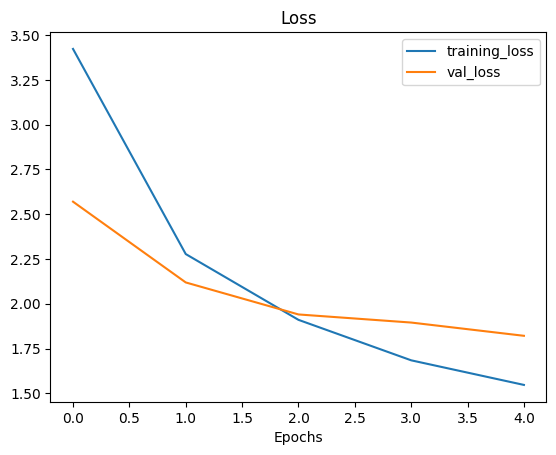

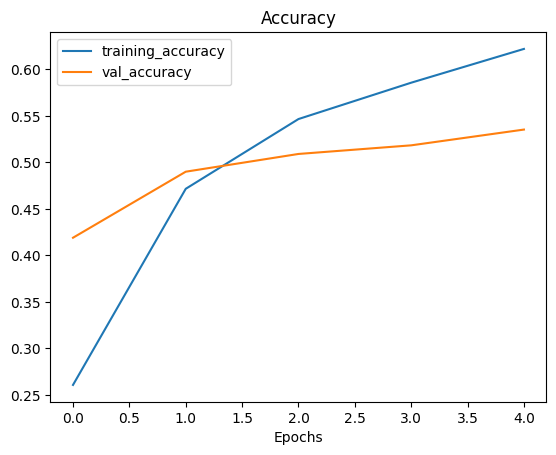

In [12]:
plot_loss_curves(history_all_classes_10_percent)

## Fine-tuning

In [13]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [14]:
# Recompile model with lower learning rate
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # learning_rate reduced by 10x
              metrics=["accuracy"])

In [15]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [16]:
# Check which layers are trainable in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10

# Fine-tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps = int(0.15 * len(test_data)),
                                                     initial_epoch = history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 51s 166ms/step - accuracy: 0.6238 - loss: 1.5391 - val_accuracy: 0.5546 - val_loss: 1.7366
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 38s 156ms/step - accuracy: 0.6691 - loss: 1.3564 - val_accuracy: 0.5614 - val_loss: 1.6780
Epoch 7/10
174/237 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - accuracy: 0.6768 - loss: 1.2771

In [ ]:
# Evaluate the whole test_data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

In [ ]:
# Compare the histories of feature extraction model with fine-tuning model
compare_historys(original_history=history_all_classes_10_percent,
                  new_history=history_all_classes_10_percent_fine_tune,
                  initial_epochs=5)

## Saving and loading our model
To use our model in an external application, we'll need to save it and export it somewhere

In [ ]:
# Save our fine-tuning model
model.save("/content/drive/MyDrive/tensorflow_course/101_food_classes_10_percent_data_model.keras")

In [ ]:
# Load an evaluate saved model
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/tensorflow_course/101_food_classes_10_percent_data_model.keras")

In [ ]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

In [ ]:
# The results from ourloaded_model (above) should be very similar to the results below
all_classes_10_percent_fine_tune_results

## Evaluating the performance of the big dog model across all different classes
Let'smake some predictions, visualize them and then later find out which predictions were the "most" wrong

In [1]:
import tensorflow as tf

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_classes_10_percent_saved_big_dog_model.zip

--2025-10-14 20:41:11--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_classes_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.207, 64.233.170.207, 74.125.200.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.207|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2025-10-14 20:41:12 ERROR 403: Forbidden.

